## Inference

In [1]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
from Autoencoder import Autoencoder
from Autoencoder_big import ImprovedAutoencoder
import yaml
import os
import cv2
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# Instantiate the model and set to eval mode
model = Autoencoder()

# Load model.pth if exists
try:
	model.load_state_dict(torch.load("models/Autoencoder_norm.pth"))
except FileNotFoundError:
	print("No model.pth found")
model.to(device)
model.eval()

# Define a transform to preprocess the image
transform = transforms.Compose([
		transforms.Resize((256,256)),
		transforms.ToTensor(),
		transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
	])

# Load data path
with open("../config.yml", "r") as file:
	config = yaml.safe_load(file)
	data_path = config["dataset_path"]

Using cuda device


In [2]:
# Load and preprocess the image
# image = Image.open(os.path.join(data_path, "CrossValidation/Annotated/B22-25_0/02816.png")) # Negative
image = Image.open(os.path.join(data_path, "CrossValidation/Annotated/B22-37_0/00045_Aug1.png")).convert("RGB") # Positive
input_image = transform(image).unsqueeze(0) # Add batch dimension
print(input_image.shape)

torch.Size([1, 3, 256, 256])


In [3]:
# Perform a forward pass to get the reconstructed image
with torch.no_grad():
    reconstructed_image = model(input_image.to(device))

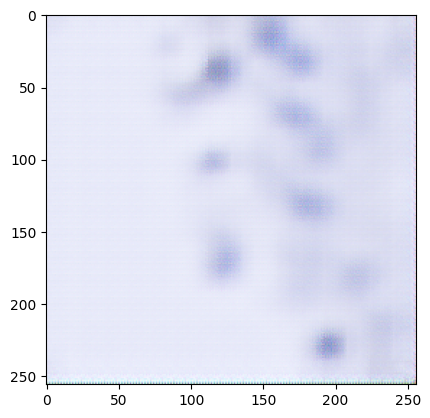

In [4]:
# plot reconstructed_image
plot_image = reconstructed_image.squeeze(0).permute(1,2,0).cpu().numpy()
plot_image = plot_image * 0.5 + 0.5
plt.imshow(plot_image)

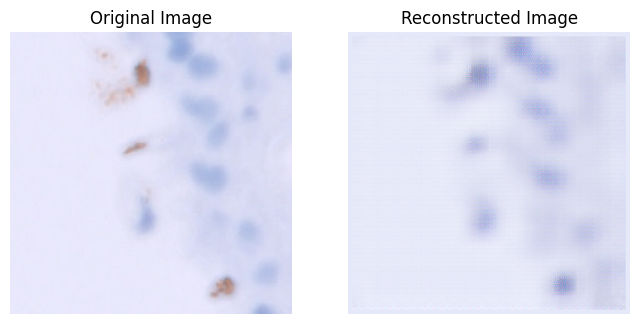

In [5]:
def postprocess(tensor, p=0):
	if tensor.dim() == 4:
		tensor = tensor.squeeze(0)
	tensor = tensor.cpu()
	tensor = tensor * 0.5 + 0.5
	tensor = tensor * 255
	tensor = tensor.clamp(0, 255)
	tensor = tensor.type(torch.uint8)
	tensor = tensor.permute(1, 2, 0).numpy()
	if p > 0:
		# center crop
		tensor = tensor[p:256-p, p:256-p, :]
		# padd again with blue color
		tensor = cv2.copyMakeBorder(tensor, p, p, p, p, cv2.BORDER_CONSTANT, value=[228, 232, 248])
	return tensor

# Convert tensors to images for visualization
input_image_np = postprocess(input_image)
reconstructed_image_np = postprocess(reconstructed_image, p=4)

# Display the original and reconstructed images
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(input_image_np)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image_np)
plt.axis("off")

plt.show()

# Patch classification

In [6]:
def check_red_fraction(orig, reco):
	# Convert the images from RGB to HSV
	input_image_hsv = cv2.cvtColor(orig, cv2.COLOR_RGB2HSV)
	reconstructed_image_hsv = cv2.cvtColor(reco, cv2.COLOR_RGB2HSV)

	# Define the hue range for red pixels as suggested
	# For -20 to 0 in HSV, which corresponds to hues 160-180 in OpenCV's scale
	input_lower_hsv1 = np.array([340, 0, 0])
	input_upper_hsv1 = np.array([360, 255, 255])

	# For 0 to 20 in HSV
	input_lower_hsv2 = np.array([0, 0, 0])
	input_upper_hsv2 = np.array([20, 255, 255])

	# Apply masks to the original image
	mask_ori1 = cv2.inRange(input_image_hsv, input_lower_hsv1, input_upper_hsv1)
	mask_ori2 = cv2.inRange(input_image_hsv, input_lower_hsv2, input_upper_hsv2)
	mask_ori = cv2.bitwise_or(mask_ori1, mask_ori2)
	count_red_ori = np.count_nonzero(mask_ori)

	# Apply masks to the reconstructed image
	mask_rec1 = cv2.inRange(reconstructed_image_hsv, input_lower_hsv1, input_upper_hsv1)
	mask_rec2 = cv2.inRange(reconstructed_image_hsv, input_lower_hsv2, input_upper_hsv2)
	mask_rec = cv2.bitwise_or(mask_rec1, mask_rec2)
	count_red_rec = np.count_nonzero(mask_rec)

	# Calculate the fraction of red pixels
	F_red = count_red_ori / (count_red_rec+1)

	return F_red

check_red_fraction(input_image_np, reconstructed_image_np)

305.0

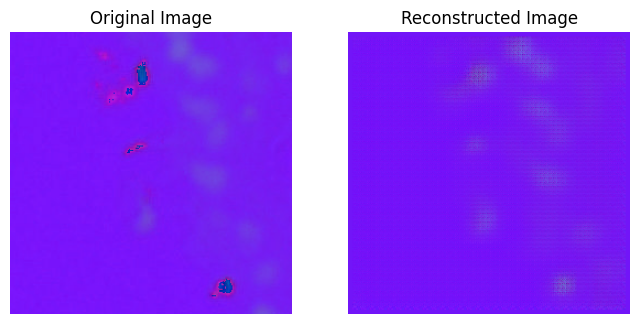

In [7]:
# visualize hsv
plt.figure(figsize=(8, 4))

input_image_hsv = cv2.cvtColor(input_image_np, cv2.COLOR_RGB2HSV)
reconstructed_image_hsv = cv2.cvtColor(reconstructed_image_np, cv2.COLOR_RGB2HSV)

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(input_image_hsv)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image_hsv)
plt.axis("off")

plt.show()

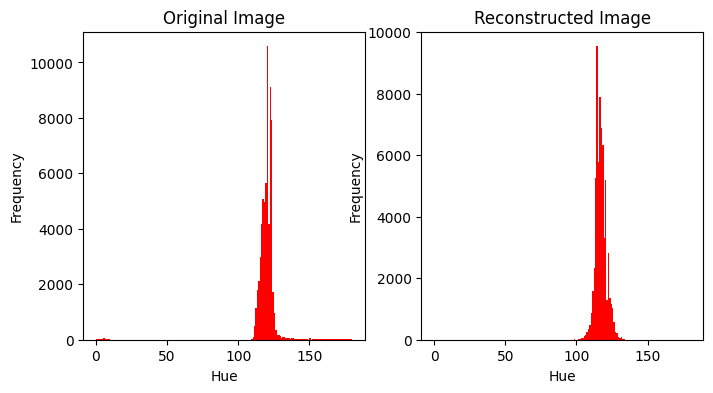

In [8]:
# histogran of hue
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.hist(input_image_hsv[:,:,0].flatten(), bins=180, range=[0,180], color='r')
plt.xlabel("Hue")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.hist(reconstructed_image_hsv[:,:,0].flatten(), bins=180, range=[0,180], color='r')
plt.xlabel("Hue")
plt.ylabel("Frequency")

plt.show()

### Simple train-val split

In [9]:
from utils import HelicoDatasetClassification
from torch.utils.data import DataLoader
from tqdm import tqdm

train_set = HelicoDatasetClassification(
	patient_id=True,
	split="train",
	train_ratio=0.8,
	random_seed=42
)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)

train_red_fracs = []
train_labels = []
train_patient_ids = []
for batch in tqdm(train_loader):
	b_orig_images = batch[0].to(device)
	b_labels = batch[1].to(device)
	train_patient_ids.extend(batch[2])
	with torch.no_grad():
		reco_images = model(b_orig_images)
	
	for i in range(len(b_orig_images)):
		train_red_fracs.append(check_red_fraction(
			postprocess(b_orig_images[i]),
			postprocess(reco_images[i])
		))
	train_labels.extend(b_labels.cpu().numpy())
train_labels = np.array(train_labels)

100%|██████████| 17/17 [00:20<00:00,  1.18s/it]


In [10]:
print(train_red_fracs[:15])

[13.58695652173913, 5.631578947368421, 2.2442307692307693, 74.0909090909091, 3.3548387096774195, 2.590909090909091, 0.20253164556962025, 0.36585365853658536, 0.0, 3.2508250825082508, 0.2962962962962963, 0.056179775280898875, 0.015151515151515152, 21.666666666666668, 4.44]


In [11]:
print(train_labels[:15])

[1 1 1 1 1 0 0 0 0 1 0 0 0 1 1]


AUC: 0.955
Optimal red fraction threshold: 1.3


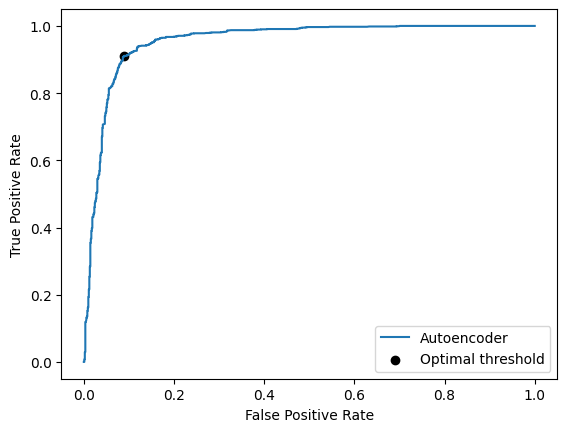

In [18]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# sort red_fracs and labels by red_fracs
train_red_fracs = np.array(train_red_fracs)
train_labels = np.array(train_labels)
inds = train_red_fracs.argsort()
sorted_red_fracs = train_red_fracs[inds]
sorted_labels = train_labels[inds]

# calculate roc curve
fpr, tpr, thresholds = roc_curve(sorted_labels, sorted_red_fracs)
# calculate AUC
auc = roc_auc_score(sorted_labels, sorted_red_fracs)
print('AUC: %.3f' % auc)

# find the closest point to (0,1)
optimal_idx = np.argmax(tpr - fpr)
optimal_red_frac = thresholds[optimal_idx]
print(f"Optimal red fraction threshold: {optimal_red_frac}")

# plot the roc curve for the model
plt.plot(fpr, tpr, label='Autoencoder')
# plot the optimal threshold
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='black', label='Optimal threshold')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

100%|██████████| 4/4 [00:04<00:00,  1.03s/it]

Accuracy: 0.937
Precision: 0.970
Recall: 0.932
F1: 0.951


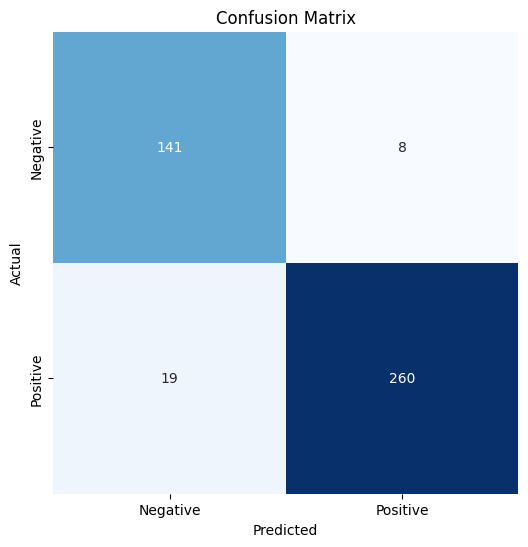

In [13]:
import seaborn as sns

val_set = HelicoDatasetClassification(
	patient_id=True,
	split="val",
	train_ratio=0.8,
	random_seed=42
)

val_loader = DataLoader(val_set, batch_size=128, shuffle=False)

val_red_fracs = []
val_labels = []
val_patient_ids = []
for batch in tqdm(val_loader):
	b_orig_images = batch[0].to(device)
	b_labels = batch[1].to(device)
	val_patient_ids.extend(batch[2])
	with torch.no_grad():
		reco_images = model(b_orig_images)
	
	for i in range(len(b_orig_images)):
		val_red_fracs.append(check_red_fraction(
			postprocess(b_orig_images[i]),
			postprocess(reco_images[i])
		))
	val_labels.extend(b_labels.cpu().numpy())
val_labels = np.array(val_labels)

# confusion matrix
y_pred = (val_red_fracs > optimal_red_frac).astype(int)
cm = confusion_matrix(val_labels, y_pred)

accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
f1 = 2 * (precision * recall) / (precision + recall)
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1: {f1:.3f}")

# plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### K-fold cross validation

In [14]:
from sklearn.model_selection import KFold
from utils import get_classification_patient_ids

dataset_path = yaml.safe_load(open("config.yml", "r"))["dataset_path"]
excel_file_path = os.path.join(dataset_path, "HP_WSI-CoordAnnotatedPatches.xlsx")
patient_ids = get_classification_patient_ids(excel_file_path)

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

aggregate_confusion_matrix = np.zeros((2, 2))

for fold, (train_index, test_index) in enumerate(kf.split(patient_ids)):
	print(f"\nStarting fold {fold + 1}/{k}")

	# Get train and test patient IDs
	train_patient_ids = [patient_ids[i] for i in train_index]
	test_patient_ids = [patient_ids[i] for i in test_index]

	# Create the datasets and dataloaders
	train_set = HelicoDatasetClassification(
		patient_id=True,
		patient_ids_to_include=train_patient_ids,
		train_ratio=1.0
	)
	test_set = HelicoDatasetClassification(
		patient_id=True,
		patient_ids_to_include=test_patient_ids,
		train_ratio=1.0
	)
	print(f"Train set size: {len(train_set)}")
	print(f"Test set size: {len(test_set)}")
	train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
	test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

	# Find the optimal threshold
	train_red_fracs = []
	train_labels = []
	train_patient_ids = []
	for batch in tqdm(train_loader):
		b_orig_images = batch[0].to(device)
		b_labels = batch[1].to(device)
		train_patient_ids.extend(batch[2])
		with torch.no_grad():
			reco_images = model(b_orig_images)
		
		for i in range(len(b_orig_images)):
			train_red_fracs.append(check_red_fraction(
				postprocess(b_orig_images[i]),
				postprocess(reco_images[i])
			))
		train_labels.extend(b_labels.cpu().numpy())

	# sort red_fracs and labels by red_fracs
	train_red_fracs = np.array(train_red_fracs)
	train_labels = np.array(train_labels)
	inds = train_red_fracs.argsort()
	sorted_red_fracs = train_red_fracs[inds]
	sorted_labels = train_labels[inds]

	# calculate roc curve and AUC
	fpr, tpr, thresholds = roc_curve(sorted_labels, sorted_red_fracs)
	auc = roc_auc_score(sorted_labels, sorted_red_fracs)

	# find the closest point to (0,1)
	optimal_idx = np.argmax(tpr - fpr)
	optimal_red_frac = thresholds[optimal_idx]

	# Evaluate the model
	test_red_fracs = []
	test_labels = []
	test_patient_ids = []
	for batch in tqdm(test_loader):
		b_orig_images = batch[0].to(device)
		b_labels = batch[1].to(device)
		test_patient_ids.extend(batch[2])
		with torch.no_grad():
			reco_images = model(b_orig_images)
		
		for i in range(len(b_orig_images)):
			test_red_fracs.append(check_red_fraction(
				postprocess(b_orig_images[i]),
				postprocess(reco_images[i])
			))
		test_labels.extend(b_labels.cpu().numpy())

	# Aggregate the results
	test_red_fracs = np.array(test_red_fracs)
	test_labels = np.array(test_labels)
	y_pred = (test_red_fracs > optimal_red_frac).astype(int)
	cm = confusion_matrix(test_labels, y_pred)
	aggregate_confusion_matrix += cm

	# Print fold results
	print(f"- Threshold: {optimal_red_frac:.3f}")
	print(f"- AUC: {auc:.3f}")


Starting fold 1/5
Train set size: 2086
Test set size: 422


100%|██████████| 4/4 [00:03<00:00,  1.23it/s]


- Threshold: 0.910
- AUC: 0.956

Starting fold 2/5
Train set size: 2243
Test set size: 265


100%|██████████| 3/3 [00:01<00:00,  1.52it/s]


- Threshold: 1.324
- AUC: 0.966

Starting fold 3/5
Train set size: 1764
Test set size: 744


100%|██████████| 6/6 [00:05<00:00,  1.06it/s]


- Threshold: 1.331
- AUC: 0.953

Starting fold 4/5
Train set size: 1848
Test set size: 660


100%|██████████| 6/6 [00:05<00:00,  1.19it/s]


- Threshold: 1.012
- AUC: 0.947

Starting fold 5/5
Train set size: 2091
Test set size: 417


100%|██████████| 4/4 [00:03<00:00,  1.29it/s]

- Threshold: 1.300
- AUC: 0.955



Aggregate results
- Accuracy: 0.906
- Precision: 0.924
- Recall: 0.914
- F1: 0.919


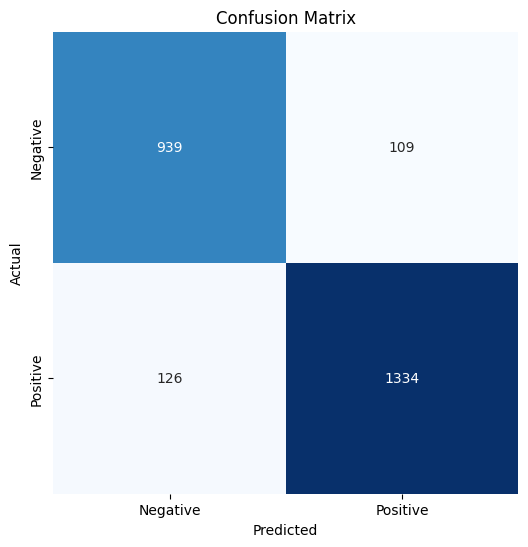

In [15]:
# Print aggregate results
cm = aggregate_confusion_matrix
accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
f1 = 2 * (precision * recall) / (precision + recall)
print(f"\nAggregate results")
print(f"- Accuracy: {accuracy:.3f}")
print(f"- Precision: {precision:.3f}")
print(f"- Recall: {recall:.3f}")
print(f"- F1: {f1:.3f}")

# plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm.astype(int), annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Compute tresh on whole Annotated for patient diagnosis

In [16]:
from utils import HelicoDatasetClassification
from torch.utils.data import DataLoader
from tqdm import tqdm

dataset = HelicoDatasetClassification(
	patient_id=True,
	split="train",
	train_ratio=1.0,
	random_seed=42
)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

red_fracs = []
labels = []
patient_ids = []
for batch in tqdm(dataloader):
	b_orig_images = batch[0].to(device)
	b_labels = batch[1].to(device)
	patient_ids.extend(batch[2])
	with torch.no_grad():
		reco_images = model(b_orig_images)
	
	for i in range(len(b_orig_images)):
		red_fracs.append(check_red_fraction(
			postprocess(b_orig_images[i]),
			postprocess(reco_images[i])
		))
	labels.extend(b_labels.cpu().numpy())

100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


AUC: 0.956
Optimal red fraction threshold: 1.3


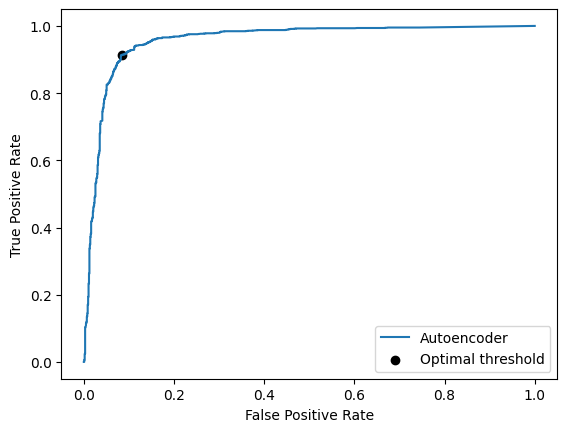

In [ ]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# sort red_fracs and labels by red_fracs
red_fracs = np.array(red_fracs)
labels = np.array(labels)
inds = red_fracs.argsort()
sorted_red_fracs = red_fracs[inds]
sorted_labels = labels[inds]

# calculate roc curve
fpr, tpr, thresholds = roc_curve(sorted_labels, sorted_red_fracs)
# calculate AUC
auc = roc_auc_score(sorted_labels, sorted_red_fracs)
print('AUC: %.3f' % auc)

# find the closest point to (0,1)
optimal_idx = np.argmax(tpr - fpr)
optimal_red_frac = thresholds[optimal_idx]
print(f"Optimal red fraction threshold: {optimal_red_frac}")

# plot the roc curve for the model
plt.plot(fpr, tpr, label='Autoencoder')
# plot the optimal threshold
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='black', label='Optimal threshold')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

# Patient Diagnosis

In [ ]:
from sklearn.model_selection import KFold
from utils import HelicoDatasetPatientDiagnosis, get_diagnosis_patient_ids
import os
import pandas as pd

dataset_path = yaml.safe_load(open("config.yml", "r"))["dataset_path"]
csv_file_path = os.path.join(dataset_path, "PatientDiagnosis.csv")
patient_ids = get_diagnosis_patient_ids(csv_file_path)

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

aggregate_confusion_matrix = np.zeros((2, 2))

for fold, (train_index, test_index) in enumerate(kf.split(patient_ids)):
	print(f"\nStarting fold {fold + 1}/{k}")

	# Get train and test patient IDs
	train_patient_ids = [patient_ids[i] for i in train_index]
	test_patient_ids = [patient_ids[i] for i in test_index]

	# Create the datasets and dataloaders
	train_set = HelicoDatasetPatientDiagnosis(
		patient_ids_to_include=train_patient_ids,
		train_ratio=1.0
	)
	test_set = HelicoDatasetPatientDiagnosis(
		patient_ids_to_include=test_patient_ids,
		train_ratio=1.0
	)
	print(f"Train set size: {len(train_set)}")
	print(f"Test set size: {len(test_set)}")
	train_loader = DataLoader(train_set, batch_size=248, shuffle=True)
	test_loader = DataLoader(test_set, batch_size=248, shuffle=False)


# if os.path.exists("temp/holdout_results.csv"):
# 	holdout_results = pd.read_csv("temp/holdout_results.csv")
# 	train_red_fracs = holdout_results["red_frac"].values
# 	train_patient_ids = holdout_results["patient_id"].values
# 	gt_patient_diagnosis = holdout_results["diagnosis"].values
# 	pred_patch_class = holdout_results["pred_patch_class"].values
# else:
train_red_fracs = []
train_patient_ids = []
gt_patient_diagnosis = []

for batch in tqdm(dataloader):
	b_orig_images = batch[0].to(device)
	train_patient_ids.extend(batch[1])
	gt_patient_diagnosis.extend(batch[2])
	with torch.no_grad():
		reco_images = model(b_orig_images)
	
	for i in range(len(b_orig_images)):
		train_red_fracs.append(check_red_fraction(
			postprocess(b_orig_images[i]),
			postprocess(reco_images[i])
		))

train_red_fracs = np.array(train_red_fracs)
train_patient_ids = np.array(train_patient_ids)
gt_patient_diagnosis = np.array(gt_patient_diagnosis)
pred_patch_class = (np.array(train_red_fracs) > optimal_red_frac).astype(int)

In [ ]:
# save in a csv file
df = pd.DataFrame({
	"patient_id": train_patient_ids,
	"diagnosis": gt_patient_diagnosis,
	"pred_patch_class": pred_patch_class,
	"red_frac": train_red_fracs
})
df.to_csv("temp/holdout_results.csv", index=False)

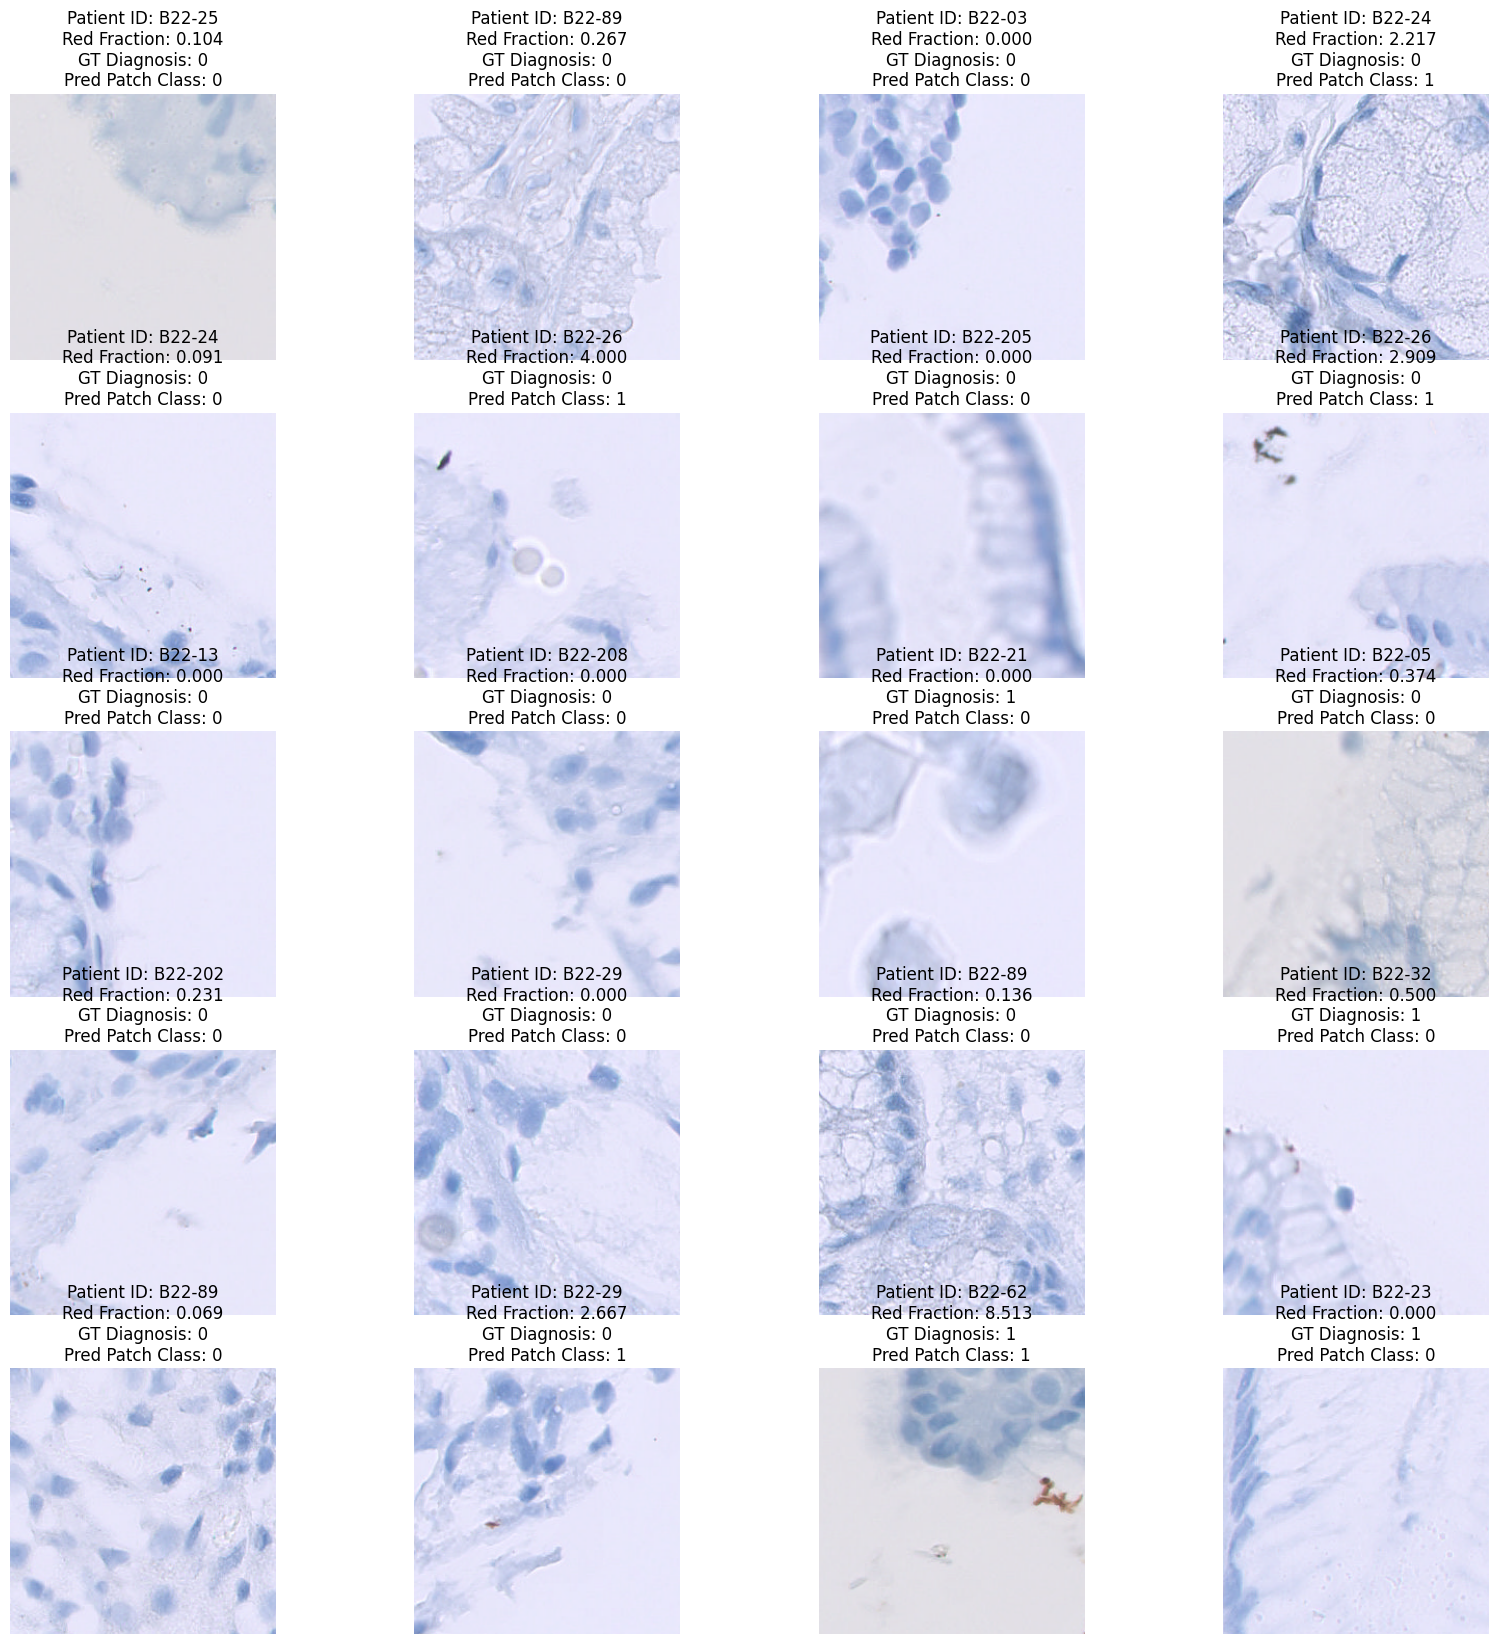

In [ ]:
# visualize 20 random images with their red fraction and diagnosis
n_images = 20
rand_inds = np.random.choice(len(train_patient_ids), n_images, replace=False)
rand_patient_ids = train_patient_ids[rand_inds]
rand_red_fracs = train_red_fracs[rand_inds]
rand_gt_patient_diagnosis = gt_patient_diagnosis[rand_inds]
rand_pred_patch_class = pred_patch_class[rand_inds]

plt.figure(figsize=(20, 20))
for i in range(n_images):
	plt.subplot(5, 4, i+1)
	plt.title(f"Patient ID: {rand_patient_ids[i]}\nRed Fraction: {rand_red_fracs[i]:.3f}\nGT Diagnosis: {rand_gt_patient_diagnosis[i]}\nPred Patch Class: {rand_pred_patch_class[i]}")
	plt.imshow(postprocess(dataset[rand_inds[i]][0]))
	plt.axis("off")
plt.show()

In [ ]:
pred_patch_class
train_patient_ids
count_by_patient = {}
positives_by_patient = {}
negatives_by_patient = {}
for i, patient_id in enumerate(train_patient_ids):
	if patient_id not in count_by_patient:
		count_by_patient[patient_id] = 0
		positives_by_patient[patient_id] = 0
		negatives_by_patient[patient_id] = 0
	count_by_patient[patient_id] += 1
	if pred_patch_class[i] == 1:
		positives_by_patient[patient_id] += 1
	else:
		negatives_by_patient[patient_id] += 1

percentage_by_patient = {}
for patient_id in count_by_patient:
	percentage_by_patient[patient_id] = positives_by_patient[patient_id] / count_by_patient[patient_id]

In [ ]:
import pandas as pd

# Create a dataframe with the results
results = pd.DataFrame({
	"Patient ID": train_patient_ids,
	"Red Fraction": train_red_fracs,
	"Pred Patch Class": pred_patch_class,
	"GT patient diagnosis": gt_patient_diagnosis,
})
results.head()

,Patient ID,Red Fraction,Pred Patch Class,GT patient diagnosis
0,B22-03,0.125000,0,0
1,B22-03,0.111111,0,0
2,B22-03,0.000000,0,0
3,B22-03,0.000000,0,0
4,B22-03,0.000000,0,0


In [25]:
# count of patches, positive patches and negative patches per patient
new_results = results.groupby("Patient ID").agg({
	"Red Fraction": "count",
	"Pred Patch Class": "sum",
	"GT patient diagnosis": "first"
})
new_results["Pred Patch Class"] = new_results["Pred Patch Class"].astype(int)
new_results = new_results.rename(columns={"Red Fraction": "Total Patches", "Pred Patch Class": "Positive Patches"})
new_results["Negative Patches"] = new_results["Total Patches"] - new_results["Positive Patches"]
new_results["Percentage of Positive Patches"] = new_results["Positive Patches"] / new_results["Total Patches"] * 100
new_results.head(20)

,Total Patches,Positive Patches,GT patient diagnosis,Negative Patches,Percentage of Positive Patches
Patient ID,,,,,
B22-03,486,23,0,463,4.732510
B22-04,287,20,0,267,6.968641
B22-05,810,61,0,749,7.530864
B22-06,891,183,0,708,20.538721
B22-07,154,14,0,140,9.090909
B22-08,321,14,0,307,4.361371
B22-09,360,28,0,332,7.777778
B22-10,2634,583,0,2051,22.133637
B22-11,1217,206,0,1011,16.926869


In [26]:
# percentage of positive patches per patient
pos_patches_per_patient = results.groupby("Patient ID")["Pred Patch Class"].mean().reset_index()
pos_patches_per_patient["Pred Patch Class"] = pos_patches_per_patient["Pred Patch Class"] * 100
pos_patches_per_patient.rename(columns={"Pred Patch Class": "Percentage of Positive Patches"}, inplace=True)

# add the patient diagnosis column
patient_diagnosis = results.groupby("Patient ID")["GT patient diagnosis"].first().reset_index()
pos_patches_per_patient = pos_patches_per_patient.merge(patient_diagnosis, on="Patient ID")

AUC: 0.875
Optimal threshold: 22.291407222914074


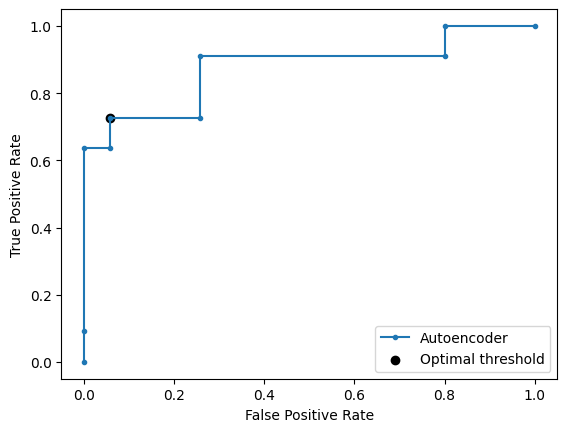

In [30]:
# sort by percentage of positive patches
pos_patches_per_patient = pos_patches_per_patient.sort_values("Percentage of Positive Patches", ascending=False)
sorted_gt = pos_patches_per_patient["GT patient diagnosis"]
sorted_preds = pos_patches_per_patient["Percentage of Positive Patches"]

# calculate roc curve
fpr, tpr, thresholds = roc_curve(sorted_gt, sorted_preds)
# calculate AUC
auc = roc_auc_score(sorted_gt, sorted_preds)
print('AUC: %.3f' % auc)

# find the closest point to (0,1)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold}")

# plot the roc curve for the model
plt.plot(fpr, tpr, label='Autoencoder', marker='.')
# plot the optimal threshold
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='black', label='Optimal threshold')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [28]:
final = pos_patches_per_patient.copy()
final ["Pred Patient Diagnosis"] = (final["Percentage of Positive Patches"] > optimal_threshold).astype(int)
final.head(20)

,Patient ID,Percentage of Positive Patches,GT patient diagnosis,Pred Patient Diagnosis
39,B22-65,70.967742,1,1
40,B22-72,60.316675,1,1
38,B22-62,48.194662,1,1
42,B22-78,42.051282,1,1
43,B22-79,35.839599,1,1
27,B22-23,31.502454,1,1
41,B22-75,30.191827,1,1
10,B22-13,26.467226,0,1
23,B22-220,22.607261,0,1
36,B22-32,22.291407,1,0


Accuracy: 0.870
Precision: 0.778
Recall: 0.636
F1: 0.700


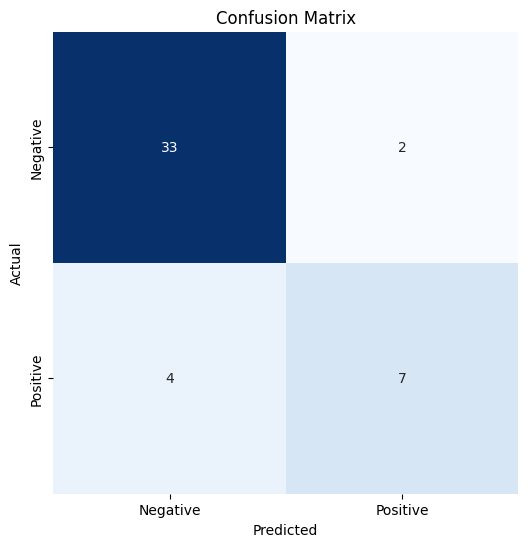

In [29]:
# confusion matrix
cm = confusion_matrix(final["GT patient diagnosis"], final["Pred Patient Diagnosis"])
accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
f1 = 2 * (precision * recall) / (precision + recall)
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1: {f1:.3f}")

# plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

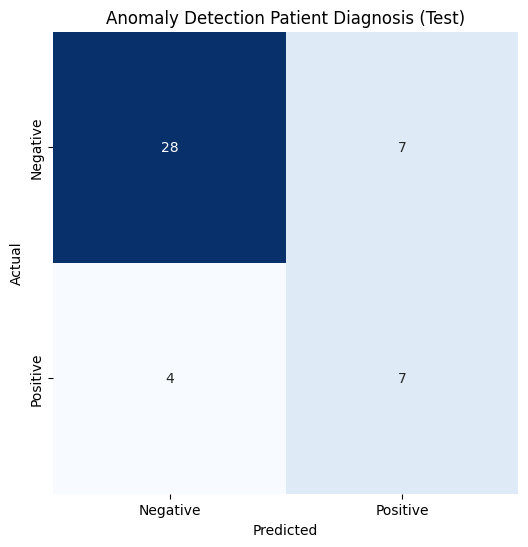

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

a = np.array([
	[28, 7],
	[4, 7]
])

# plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(a, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Anomaly Detection Patient Diagnosis (Test)")
plt.show()